# Integrating the HFM library into pyKasso #
C. Fandel 2020 <br>
Purpose: replace the skfmm module with the agd-hfm module to improve network generation capability

TO-DO:

*Necessary*
- [X] add cost map
- [X] make cost map reflect realistic values
- [X] add DxV and DyV (x and y components of gradient in each cell of array)
    - [X] option to calculate from DEM
        - [X] rotate DEM csv by 90 degrees
- [X] add alpha map (travel cost in same direction as gradient)
- [X] add beta map (travel cost perpendicular to gradient)
- [X] convert cost map into HFM library's input format
- [X] use the HFM library to compute travel time map and paths
- [ ] make sure GSLIB import for geology still works
- [ ] convert paths to node/link format
- [ ] allow iteration over multiple outlets
- [ ] allow assigning specific inlets to specific outlets
- [ ] add option in settings file to shuffle inlets and/or shuffle outlets

*Useful (save for later)*
- [ ] add option to import orientations from GSLIB file
- [ ] label geology colorbar in show_catchment() so we know which colors correspond to karstifiable units
- [ ] replace all code_ functions with cost_ functions
- [ ] add to get, set, update, and show functions
    - [ ] topography
    - [ ] cost
- [ ] add/update plotting functions (use contourf, add legends, add options for what things to plot)
- [ ] rename X,Y indices to ix,iy to reduce confusion with grid

### Issues ###
Next: convert conduits to a network?

### Setup & imports ###
Need to import a local version of pykasso be able to make and test changes.
Use one of the two methods below (but not both).
Question: Is one way better than the other in some way?

In [1]:
method = 2

#Method 1: using importlib
if method==1:
    import importlib.util
    spec = importlib.util.spec_from_file_location('pykasso', 'C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso/base.py')
    pk = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pk)

#Method 2: setting the path variable to the path to the local version 
#This version allows reloading the module to see changes
if method==2:
    import sys
    sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
    import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [2]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import numpy as np
from matplotlib import pyplot as plt

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann
#from agd.Plotting import quiver
#from agd import LinearParallel as lp
#from agd import AutomaticDifferentiation as ad
#norm_infinity = ad.Optimization.norm_infinity

#os.chdir('C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso')
os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

### Test on built-in Betteraz system ###

CAUTION: You are using the development version of this package.


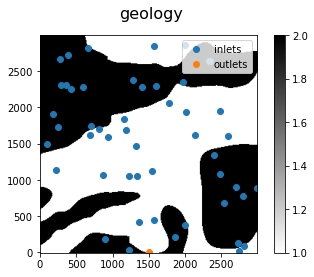

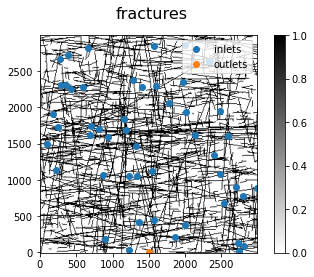


 This network contains  6  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


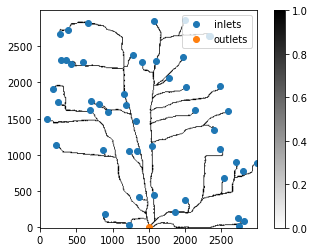

In [53]:
importlib.reload(pk)

catchment = pk.SKS('inputs/betteraz/settings_dev.yaml')
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show()

In [29]:
catchment.conduits[0].nodes
catchment.nodeID

5853

### Simple one-valley system ###

CAUTION: You are using the development version of this package.


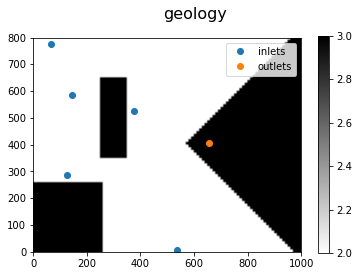

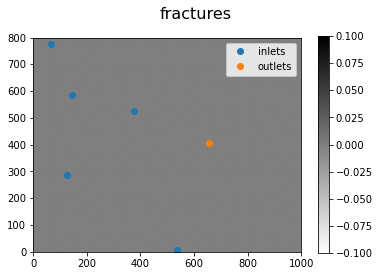

Iteration 0
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 1
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 2
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.017 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 3
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

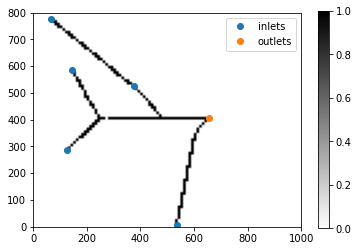

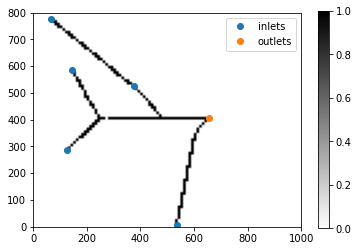

In [295]:
importlib.reload(pk)

catchment = pk.SKS('inputs/valley1/settings.yaml', rand_seed=1) #import settings and options from input folder
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show_hfm()
catchment.show(data=catchment.maps['karst_hfm'][-1])


 This network contains  2  connected components



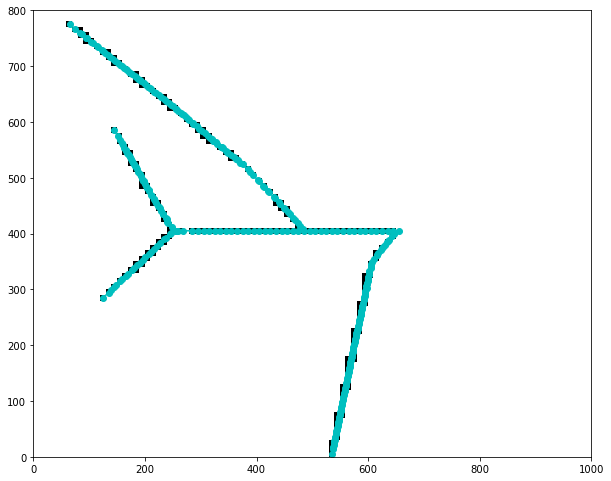

In [306]:
f = plt.figure(figsize=(10,10))
plt.imshow(catchment.maps['karst_hfm'][-1], origin='lower', extent=catchment.grid.extent, cmap='gray_r')
catchment.karst_simulations[0].network

nodes = catchment.karst_simulations[0].network['nodes']
edges = catchment.karst_simulations[0].network['edges']

run = True
if run==True:
    for n in range(len(nodes)):
        plt.scatter(nodes[n][0],nodes[n][1], c='c')
    for edge in enumerate(edges):
            #print(edge, edge[1][1])
            #print(nodes[nodes[0]==edge[1][0]])
            fromX = nodes[edge[1][0]][0]
            fromY = nodes[edge[1][0]][1]
            toX   = nodes[edge[1][1]][0]
            toY   = nodes[edge[1][1]][1]
            #print('fromX',fromX,'fromY',fromY,'toX',toX,'toY',toY)
            plt.plot([fromX,toX],[fromY,toY], c='c') #plot links
#print(nodes)
#print(edges)




 This network contains  2  connected components



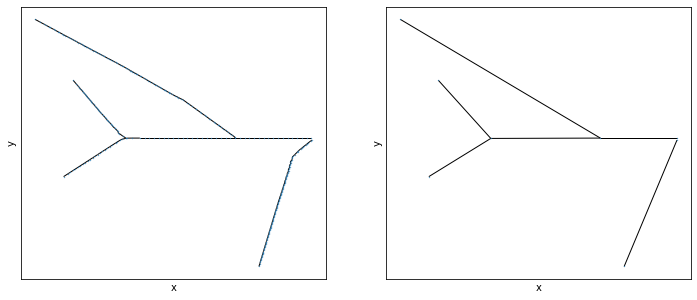

In [310]:
import karstnet as kn
k = kn.KGraph(edges,nodes)

k.plot()

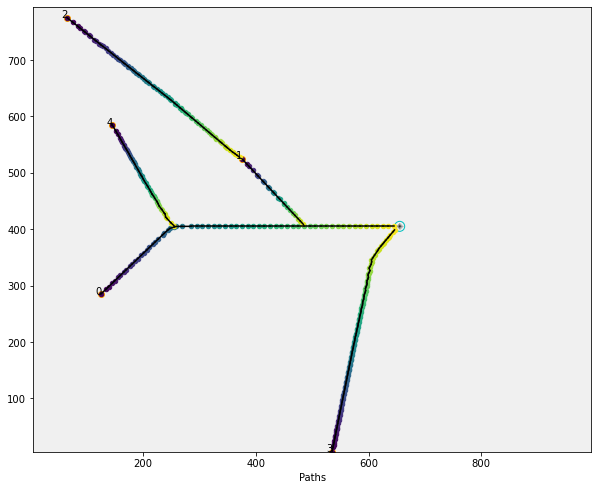

In [294]:
#Plot paths:
f = plt.figure(figsize=(10,10))
f.add_subplot(111, aspect='equal')
plt.xlabel('Paths')
#plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['alpha'][0], cmap='gray_r')
plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['phi'], cmap='gray')
plt.scatter(catchment.inlets_hfm[:,0],  catchment.inlets_hfm[:,1], c='orange')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], marker='o', edgecolor='c', facecolor='none', s=100)
for i,inlet in enumerate(catchment.inlets_hfm):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(catchment.conduits_hfm):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        #plt.plot(pathX,pathY, c='gray')

#Plot conduits:
for conduit in catchment.conduits:
    #convert to pandas df for plotting and ease of indexing
    nodes = pd.DataFrame(conduit.nodes, columns=['ID', 'x','y','nodeType'])
    links = pd.DataFrame(conduit.edges, columns=['InNode','OutNode'])
    
    for n,node in enumerate(conduit.nodes):
        if node[3] == 2:
            plt.scatter(node[1],node[2], c='r', s=50)
        else:
            plt.scatter(node[1],node[2], s=20, color=plt.cm.get_cmap('viridis')(n/len(conduit.nodes)))
    
    for e, edge in enumerate(conduit.edges):
        #print(e,edge)
        try:
            fromX = nodes.x[nodes.ID==edge[0]].values[0]
            fromY = nodes.y[nodes.ID==edge[0]].values[0]
            toX   = nodes.x[nodes.ID==edge[1]].values[0]
            toY   = nodes.y[nodes.ID==edge[1]].values[0]
        except:
            fromX = np.nan; fromY = np.nan; toX = np.nan; toY = np.nan
        #print('fromX',fromX,'fromY',fromY,'toX',toX,'toY',toY)
        plt.plot([fromX,toX],[fromY,toY], c='k') #plot links

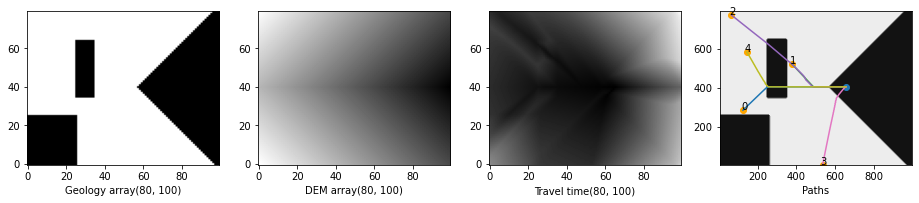

In [70]:
#Plot results:
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.xlabel('Geology array'+str(catchment.geology.data['geology']['data'].shape))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', cmap='gray_r') #darker=faster

f.add_subplot(152, aspect='equal')
plt.xlabel('DEM array'+str(catchment.geology.data['topography']['data'].shape))
plt.imshow(catchment.geology.data['topography']['data'], origin='lower', cmap='gray') #darker=faster

f.add_subplot(153, aspect='equal')
plt.xlabel('Travel time'+str(catchment.fastMarchingOutput['values'].shape))
plt.imshow(catchment.fastMarchingOutput['values'], origin='lower', cmap='gray') 
#plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['phi']) #darker=faster

f.add_subplot(154, aspect='equal')
plt.xlabel('Paths')
plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['alpha'][0], cmap='gray_r')
plt.scatter(catchment.inlets_hfm[:,0],  catchment.inlets_hfm[:,1], c='orange')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1])
for i,inlet in enumerate(catchment.inlets_hfm):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(catchment.conduits_hfm):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(catchment.conduits_hfm)))

### Run on Gottesacker 2D ###

CAUTION: You are using the development version of this package.


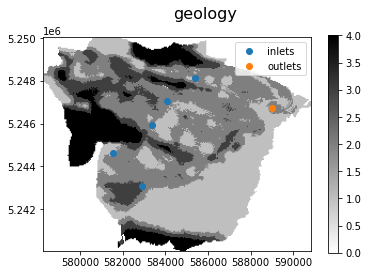

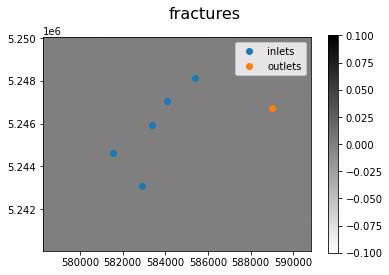

iteration 0
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.057 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
iteration 1
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.058 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
iteration 2
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.071 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
iteration 3
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.067 s.
Field geodesicSolver defaults

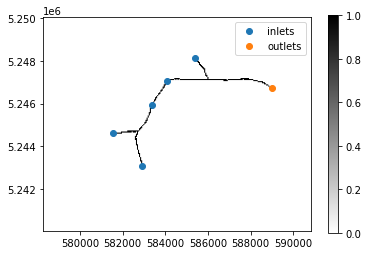

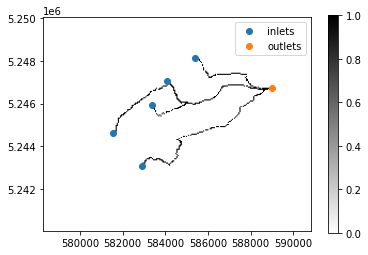

In [30]:
importlib.reload(pk)

catchment = pk.SKS('notebooks/inputs/gottesacker/settings.yaml', rand_seed=1) #import settings and options from input folder
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show()
catchment.show_hfm()

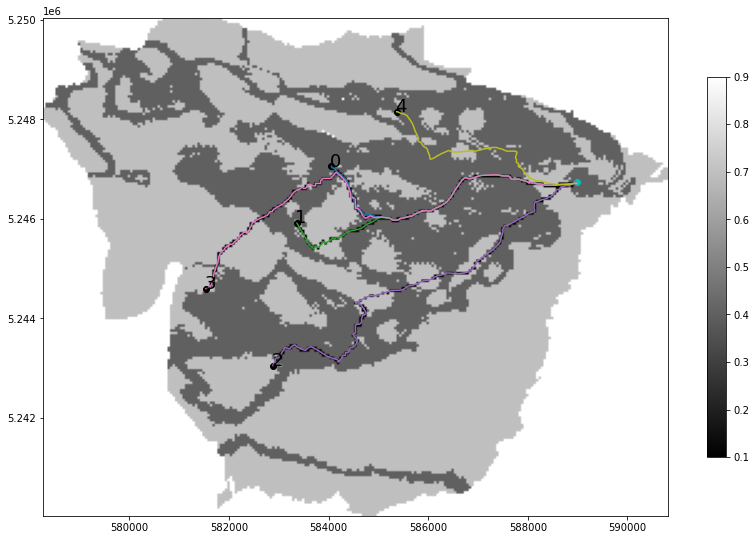

In [31]:
#Show karst in more detail:
f,ax = plt.subplots(1,1, figsize=(14,14))
#ax.grid()
#ax.scatter(catchment.grid.X, catchment.grid.Y, s=1, c='k')
#ax.scatter(catchment.grid.xlimits, catchment.grid.ylimits, s=1, c='r')

m = ax.imshow(catchment.maps['cost'][-1], extent=catchment.grid.extent, origin='lower', cmap='binary_r')
#m = ax.imshow(catchment.geology.data['topography']['data'], extent=extent, origin='lower', cmap='binary_r')
plt.colorbar(m, ax=ax, shrink=0.5)

paths = catchment.conduits_hfm
for i,iteration in enumerate(catchment.conduits_hfm):
    for path in iteration:                                  #loop over paths (one per tip/starting point)
        pathX = path[0,:]                               #get list of X coord
        pathY = path[1,:]
        ax.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(i/len(catchment.conduits_hfm)))
ax.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='c')
inlets  =  np.asarray(catchment.inlets)[:,:2]
ax.scatter(inlets[ :,0],  inlets[:,1], c='k')
for i,inlet in enumerate(catchment.inlets):
    plt.annotate(str(inlet[2]), (inlet[0]-30,inlet[1]), fontsize=18)     #label inlet iteration order


#### Original and recommended settings ####
*Velocity:* higher for easier-to-traverse fm like aquifer <br>
*Cost:* lower for easier-to-traverse fm like aquifer <br>

**Values used in HFM (for cost):**<br>
```
Ckarst          = 0.2    #travel cost in karstifiable unit (should be low)
Cnonkarst       = 0.6    #travel cost in nonkarst unit (should be high)
Cfracture       = 0.05   #travel cost in fractures
Cconduit        = 0.1    #travel cost in conduits (should be low)
Cobstacle       = 0.8    #travel cost through obstacles (should be high)
Cout            = 0.999  #travel cost in areas outside model bound (should be very high)
```
**Original values (for velocity):**
```
code aquifere   = 2 
code aquiclude  = 1 
code faults     = 4 
code fractures  = 3
code conduits   = 5 
code out        = 0.1 
```

In [34]:
print(catchment.inlets)
[item[:2] for item in catchment.inlets if item[2] == 0]

[(75.0, 725.0, 0), (495.0, 35.0, 1), (395.0, 35.0, 1), (445.0, 165.0, 2), (855.0, 15.0, 2)]


[(75.0, 725.0)]

In [4]:
#View settings:
print('geology id',       catchment.get_geology_id())
print('geology velocity', catchment.get_geology_velocity())
print('geology cost',     catchment.get_geology_cost())
print('\ncode aquifere\t',    catchment.get_code_aquifere(),
      '\ncode aquiclude\t',   catchment.get_code_aquiclude(),
      '\ncode faults\t',      catchment.get_code_faults(),
      '\ncode fractures\t',   catchment.get_code_fractures(),
      '\ncode conduits\t',    catchment.get_code_conduits(),
      '\ncode out\t',         catchment.get_code_out())
catchment.settings

geology id [2, 3]
geology velocity [2, 1]
geology cost [0.2, 0.6]

code aquifere	 2 
code aquiclude	 1 
code faults	 4 
code fractures	 3 
code conduits	 5 
code out	 0.1


{'x0': 0,
 'y0': 0,
 'xnum': 100,
 'ynum': 80,
 'dx': 10,
 'dy': 10,
 'data_has_polygon': False,
 'polygon_data': 'inputs/polygon.txt',
 'inlets_mode': 'import',
 'inlets_data': 'inputs/valley1/inlets.csv',
 'inlets_number': 1,
 'outlets_mode': 'import',
 'outlets_data': 'inputs/valley1/outlets.csv',
 'outlets_number': 1,
 'geological_mode': 'import',
 'geological_datafile': 'inputs/valley1/geology2D.gslib',
 'topography_mode': 'csv',
 'topography_datafile': 'inputs/valley1/dem.csv',
 'orientation_mode': 'topo',
 'faults_mode': 'null',
 'faults_datafile': 'inputs/faults.gslib',
 'fractures_mode': 'random',
 'fractures_datafile': 'inputs/fractures.gslib',
 'fractures_densities': [5.83e-05,
  1.38e-05,
  2.22e-05,
  2.5e-05,
  4.16e-05,
  6.66e-05,
  '5e-5'],
 'fractures_min_orientation': [0, 15, 30, 60, 105, 120, 150],
 'fractures_max_orientation': [15, 30, 45, 105, 120, 150, 180],
 'fractures_alpha': 2,
 'fractures_min_length': 50,
 'fractures_max_length': 800,
 'code_out': 0.1,
 'code

### Inputs/outputs for fast-marching ###
For compute_time_map() using skfmm: <br>
```
self.maps['time'][iteration] = skfmm.travel_time(self.maps['phi'], self.maps['velocity'][iteration], dx=self.grid.dx, order=2)
```
- phi map - where the travel time=0, i.e. the target location(s) for the base level (and springs?) (array of 0s and 1s of dim (xres,yres))
    - from compute_phi_map(), needs:
        - outlets
- velocity map - how easy it is to travel through each cell (array of dim (xres,yres), larger values=easier to travel through) 
    - from compute_velocity_map(), needs:
       - code_aquifere
       - code_aquiclude
       - code_out
- dx - cell length in each dimension (array: [dx,dy])
- order - 1 or 2 (default), order of computational stencil to use in updating points (?)

For agd-hfm: <br>
```
hfmIn = Eikonal.dictIn({
    'model':             'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])
for seed in springs:
    hfmIn['seed'] = seed
    for tip in tips:
        hfmIn['tips'] = [tip]
        hfmIn['metric']    =  F
        hfmOut = hfmIn.Run()
        paths = hfmOut['geodesics']
``` 
       
- seed - coordinates of travel time=0 location, i.e. the spring the conduits are traveling to (array of [x y z])
- tips - coordinates of starting points for walkers, i.e. the inlets (array of [[x1 y1 z1] [x2 y2 z2]]
- metric - travel cost through each cell, i.e. the inverse of the velocity (array of cost values, higher=slower to travel through). If using anisotropic FM, this will include travel cost both parallel and perpendicular to the cell's gradient.
    - to calculate travel cost metric, need:
        - DxV,DyV,DzV: x and y components of gradient in each cell of array, calculate from DEM or from geologic model orientations in each cell (arrays of dim (xres,yres)).
        - alpha: travel cost in same direction as gradient (array of dim (xres,yres) of values between 0 and 1, higher=slower)
        - beta: travel cost perpendicular to gradient (same format as alpha)
- model - which fast-marching algorithm to use (string, either Riemann2, Riemann3, Isotropic2, Isotropic3).

